<a href="https://colab.research.google.com/github/Thomas-A1/FeedForward/blob/main/Image_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Feed Forward Deep Neural Network for CINIC-10 image classification

#### =====================================
#### STEP 1: IMPORTING THE REQUIRED LIBRARIES ####
#### =====================================

In [11]:
import torch                    # Main PyTorch library for tensors and operations
import torch.nn as nn          # Neural network building blocks (layers, activations)
import torch.optim as optim    # Optimizers (Adam, SGD, etc.)
import torch.nn.functional as F # Functional interface (loss functions, activations)
import torchvision             # Computer vision utilities (datasets, transforms)
import torchvision.transforms as transforms  # Image preprocessing transformations

import numpy as np             # Numerical operations
import matplotlib.pyplot as plt # Plotting
import seaborn as sns          # Statistical visualization
from sklearn.metrics import classification_report, confusion_matrix
import os
from collections import defaultdict
import time

Mounting Google Drive to access datasets

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### =====================================
#### STEP 2: DATA LOADING AND PREPROCESSING ####
#### =====================================

In [13]:
def create_data_transforms():
    """
    Create data preprocessing transformations

    Key Concept: PyTorch transforms are applied on-the-fly during data loading
    which is more memory efficient than preprocessing everything at once.

    transforms.ToTensor() - Converts the image into a PyTorch Tensor and changes
    data range from [0, 255] to [0.0, 1.0].And changes dimension order from (H, W, C) to (C, H, W)

    transforms.Normalize(mean=[...], std=[...]) - normalized_value = (original_value - mean[c]) / std[c]
    Centers the data and ensures one channle does not dominate the other. Avoid exploding gradients
    """
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    print("Data Transforms Created:")
    print("  1. Convert to Tensor (0-1 range)")
    print("  2. Normalize with ImageNet statistics")

    return train_transform, test_transform


def load_cinic10_data(data_path, batch_size=128, train_sample_percent=100, val_sample_percent=100, test_sample_percent=100, random_seed=42):
    """
    Load CINIC-10 dataset from a local directory and create data loaders.
    Now supports subsampling training, validation, and test data.
    """
    print(f"\nLoading CINIC-10 Dataset from {data_path}...")
    print("=" * 50)
    print(f"Using {train_sample_percent}% of training data")
    print(f"Using {val_sample_percent}% of validation data")
    print(f"Using {test_sample_percent}% of test data")


    # Get transforms
    train_transform, test_transform = create_data_transforms()

    # Load the FULL datasets
    full_train_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'train'),
        transform=train_transform
    )
    full_valid_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'valid'),
        transform=test_transform
    )
    full_test_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'test'),
        transform=test_transform
    )

    # Subsample training if requested
    if train_sample_percent < 100:
        num_total = len(full_train_dataset)
        num_samples = int(num_total * train_sample_percent / 100)
        torch.manual_seed(random_seed)
        indices = torch.randperm(num_total)[:num_samples]
        train_dataset = torch.utils.data.Subset(full_train_dataset, indices)
        print(f"Created training subset: {len(train_dataset)}/{num_total}")
    else:
        train_dataset = full_train_dataset
        print(f"Training samples: {len(train_dataset)}")

    # Subsample validation if requested
    if val_sample_percent < 100:
        num_total_val = len(full_valid_dataset)
        num_samples_val = int(num_total_val * val_sample_percent / 100)
        torch.manual_seed(random_seed)
        val_indices = torch.randperm(num_total_val)[:num_samples_val]
        valid_dataset = torch.utils.data.Subset(full_valid_dataset, val_indices)
        print(f"Created validation subset: {len(valid_dataset)}/{num_total_val}")
    else:
        valid_dataset = full_valid_dataset
        print(f"Validation samples: {len(valid_dataset)}")

    # Subsample test if requested
    if test_sample_percent < 100:
        num_total_test = len(full_test_dataset)
        num_samples_test = int(num_total_test * test_sample_percent / 100)
        torch.manual_seed(random_seed)
        test_indices = torch.randperm(num_total_test)[:num_samples_test]
        test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)
        print(f"Created test subset: {len(test_dataset)}/{num_total_test}")
    else:
        test_dataset = full_test_dataset
        print(f"Test samples: {len(test_dataset)}")


    # Data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    class_names = full_train_dataset.classes
    return train_loader, valid_loader, test_loader, class_names, full_valid_dataset, full_test_dataset

####==============================================
#### STEP 3: MODEL ARCHITECTURE: NEURAL NETWORK CLASS ####
####==============================================

In [14]:
class FeedForwardNet(nn.Module):
    """
    Feed Forward Neural Network Class

    - nn.Module is the base class for all neural network modules
    - __init__() to set up layers
    - forward() to specify how data flows through the network

    """

    def __init__(self, input_size=3072, num_classes=10):
        """
        Args:
            input_size: Number of input features (32*32*3 = 3072 for flattened images)
            num_classes: Number of output classes (10 for CINIC-10)
        """
        super().__init__()  # Initialize parent class. Track parameters

        print("Creating Feed Forward Network Architecture:")
        print("=" * 50)

        # Define layers (but don't connect them yet - that happens in forward())

        # First Hidden Layer: 3072 → 512
        self.fc1 = nn.Linear(input_size, 512)
        print(f"Layer 1: Linear({input_size} → 512)")

        # Batch Normalization for first layer
        self.bn1 = nn.BatchNorm1d(512)
        print("         + BatchNorm1d(512)")

        # Dropout for regularization
        self.dropout1 = nn.Dropout(0.3)
        print("         + Dropout(0.3)")

        # Second Hidden Layer: 512 → 256
        self.fc2 = nn.Linear(512, 256)
        print(f"Layer 2: Linear(512 → 256)")

        self.bn2 = nn.BatchNorm1d(256)
        print("         + BatchNorm1d(256)")

        self.dropout2 = nn.Dropout(0.3)
        print("         + Dropout(0.3)")

        # Third Hidden Layer: 256 → 128
        self.fc3 = nn.Linear(256, 128)
        print(f"Layer 3: Linear(256 → 128)")

        self.bn3 = nn.BatchNorm1d(128)
        print("         + BatchNorm1d(128)")

        self.dropout3 = nn.Dropout(0.3)
        print("         + Dropout(0.3)")

        # Output Layer: 128 → 10
        self.fc4 = nn.Linear(128, num_classes)
        print(f"Output:  Linear(128 → {num_classes})")
        print("         + Softmax (applied during training)")

        print("\nTotal Parameters:")
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"  Total: {total_params:,}")
        print(f"  Trainable: {trainable_params:,}")

    def forward(self, x):
        """
        This is where we actually connect the layers and apply activations

        Args:
            x: Input tensor of shape (batch_size, 3072)

        Returns:
            Output tensor of shape (batch_size, 10)
        """

        # First Hidden Layer
        x = self.fc1(x)           # Linear transformation: W1 * x + b1
        x = self.bn1(x)           # Batch normalization
        x = F.relu(x)             # ReLU activation: max(0, x)
        x = self.dropout1(x)      # Randomly set 30% of neurons to 0

        # Second Hidden Layer
        x = self.fc2(x)           # Linear transformation: W2 * x + b2
        x = self.bn2(x)           # Batch normalization
        x = F.relu(x)             # ReLU activation
        x = self.dropout2(x)      # Dropout

        # Third Hidden Layer
        x = self.fc3(x)           # Linear transformation: W3 * x + b3
        x = self.bn3(x)           # Batch normalization
        x = F.relu(x)             # ReLU activation
        x = self.dropout3(x)      # Dropout

        # Output Layer (no activation here - will be handled by loss function)
        x = self.fc4(x)           # Linear transformation: W4 * x + b4

        return x

#### ===================
#### DATA SANITY CHECK
#### ===================
Verifying if the data pipeline is correct before training

In [15]:
def show_sample_data(data_loader, class_names):
    """
    Visualize sample images from the dataset
    """
    print("\nSample Images from Dataset:")
    print("=" * 30)

    # Get one batch
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # [batch_size, channels, height, width]
    print(f"Batch shape: {images.shape}")
    # [batch_size]
    print(f"Labels shape: {labels.shape}")

    # Show first 8 images
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for idx in range(8):
        ax = axes[idx // 4, idx % 4]

        # Convert tensor to displayable format
        img = images[idx]
        img = img.permute(1, 2, 0)  # Change from [C,H,W] to [H,W,C]
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1)  # Ensure values are in [0,1]

        ax.imshow(img)
        ax.set_title(f'{class_names[labels[idx]]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

#### =========================
#### STEP 4: TRAINING FUNCTION ####
#### =========================

In [16]:
def train_model(model, train_loader, val_loader, criterion, num_epochs=50, device=None):
    """
    Train the neural network with validation after each epoch.
    """

    print("\nStarting Model Training...")
    print("=" * 50)

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Optimizer + scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5) # Removed scheduler

    # Move model to device
    model = model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    print(f"\nTraining for {num_epochs} epochs...")
    print("Format: Epoch [batch/total] Loss: X.XXX Acc: XX.X%")
    print("-" * 60)

    for epoch in range(num_epochs):
        # -------------------- TRAINING --------------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)  # Flatten

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # FIX: Correctly print batch index and total batches
            if batch_idx % 100 == 0: # Print every 100 batches or the first batch
                 print(f'Epoch {epoch+1:2d} [{batch_idx:3d}/{len(train_loader)}] '
                      f'Loss: {loss.item():.3f} '
                      f'Acc: {100.*correct/total:.1f}% '
                      f'LR: {optimizer.param_groups[0]["lr"]:.6f}')


        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # -------------------- VALIDATION --------------------
        # FIX: Unpack 5 values from evaluate_model
        val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, criterion, device, verbose=False)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # scheduler.step() # Removed scheduler step

        print(f'Epoch {epoch+1:2d} Summary: '
              f'Train Loss: {epoch_loss:.3f} Train Acc: {epoch_acc:.1f}% | '
              f'Val Loss: {val_loss:.3f} Val Acc: {val_acc:.1f}%')
        print("-" * 60)

    print("Training completed!")
    return history

#### ==========================
#### STEP 5: EVALUATION FUNCTION
#### ==========================

In [17]:
# Model Evaluation
def evaluate_model(model, data_loader, criterion, device, verbose=True):
    """
    Evaluate model performance on any dataset (validation or test).
    Returns loss, accuracy, predictions, targets, and confidence scores.
    """

    if verbose:
        print("\nEvaluating Model...")
        print("=" * 30)

    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_predictions, all_targets, all_confidences = [], [], []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)  # Flatten

            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Get confidence scores (probabilities)
            # Apply softmax to the raw outputs to get probabilities
            probabilities = torch.softmax(outputs, dim=1)
            # For each prediction, get the probability of the predicted class
            confidences = torch.max(probabilities, dim=1).values


            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())


    avg_loss = total_loss / len(data_loader)
    accuracy = 100. * correct / total

    if verbose:
        print(f'Loss: {avg_loss:.4f}')
        print(f'Accuracy: {accuracy:.2f}% ({correct}/{total})')

    return avg_loss, accuracy, all_predictions, all_targets, all_confidences # Return confidences

#### ============================
#### STEP 6: VISUALIZATION FUNCTIONS
#### ============================

In [18]:
def plot_training_history(history):
    """
    Plot training curves
    """
    print("\nPlotting Training History...")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    # FIX: Use 'val_acc' instead of 'test_acc' and update label
    ax1.plot(history['train_acc'], label='Training Accuracy', color='blue')
    ax1.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    # FIX: Use 'val_loss' instead of 'test_loss' and update label
    ax2.plot(history['train_loss'], label='Training Loss', color='blue')
    ax2.plot(history['val_loss'], label='Validation Loss', color='red')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(predictions, targets, class_names):
    """
    Plot confusion matrix
    """
    print("\nGenerating Confusion Matrix...")

    cm = confusion_matrix(targets, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm

def show_classification_report(predictions, targets, class_names):
    """
    Show detailed classification metrics
    """
    print("\nClassification Report:")
    print("=" * 50)
    print(classification_report(targets, predictions, target_names=class_names))

In [19]:
# Visualize Sample Predictions with Probabilities

def visualize_sample_predictions(model, data_loader, class_names, num_images=10, device=None):
    """
    Visualizes sample test images, their true labels, predicted labels,
    and the probability distribution predicted by the model.
    """
    print(f"\nVisualizing {num_images} Sample Test Predictions...")
    print("=" * 50)

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval() # Set model to evaluation mode
    images_to_show = []
    labels_to_show = []
    predictions_to_show = []
    probabilities_to_show = []

    # Get a batch of data
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Select a random subset of images from the batch
    if num_images > images.size(0):
        num_images = images.size(0)
        print(f"Warning: Requested {num_images} images, but batch size is {images.size(0)}. Showing {num_images} images.")

    random_indices = torch.randperm(images.size(0))[:num_images]
    sample_images = images[random_indices]
    sample_labels = labels[random_indices]

    # Move samples to device and flatten
    sample_images_device = sample_images.to(device)
    sample_images_flat = sample_images_device.view(sample_images_device.size(0), -1)

    # Get model outputs and probabilities
    with torch.no_grad():
        outputs = model(sample_images_flat)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    sample_predictions = predicted.cpu().numpy()
    sample_probabilities = probabilities.cpu().numpy()

    # Prepare for plotting
    images_to_show = sample_images.permute(0, 2, 3, 1).numpy() # Convert from [N, C, H, W] to [N, H, W, C]
    labels_to_show = sample_labels.numpy()
    predictions_to_show = sample_predictions
    probabilities_to_show = sample_probabilities


    # Plotting
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3)) # 2 columns: Image + Probabilities

    for i in range(num_images):
        # Plot Image
        ax_img = axes[i, 0]
        img = images_to_show[i]
        # Denormalize for display
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        ax_img.imshow(img)
        ax_img.set_title(f"True: {class_names[labels_to_show[i]]}\nPred: {class_names[predictions_to_show[i]]}")
        ax_img.axis('off')

        # Plot Probability Distribution
        ax_prob = axes[i, 1]
        probabilities = probabilities_to_show[i]
        bars = ax_prob.bar(class_names, probabilities)
        ax_prob.set_ylim(0, 1.1) # Set y-limit for probabilities
        ax_prob.set_ylabel("Probability")
        ax_prob.set_title("Class Probabilities")
        ax_prob.tick_params(axis='x', rotation=45)

        # Highlight the predicted bar
        bars[predictions_to_show[i]].set_color('red')


    plt.tight_layout()
    plt.show()

#### =======================
#### MAIN EXECUTION FUNCTION
#### =======================

PYTORCH FEED-FORWARD NEURAL NETWORK
FOR CINIC-10 IMAGE CLASSIFICATION

Loading CINIC-10 Dataset from /content/drive/MyDrive/cinic-10...
Using 100% of training data
Using 100% of validation data
Using 20% of test data
Data Transforms Created:
  1. Convert to Tensor (0-1 range)
  2. Normalize with ImageNet statistics
Training samples: 90018
Validation samples: 90098
Created test subset: 18030/90152

Sample Images from Dataset:
Batch shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])


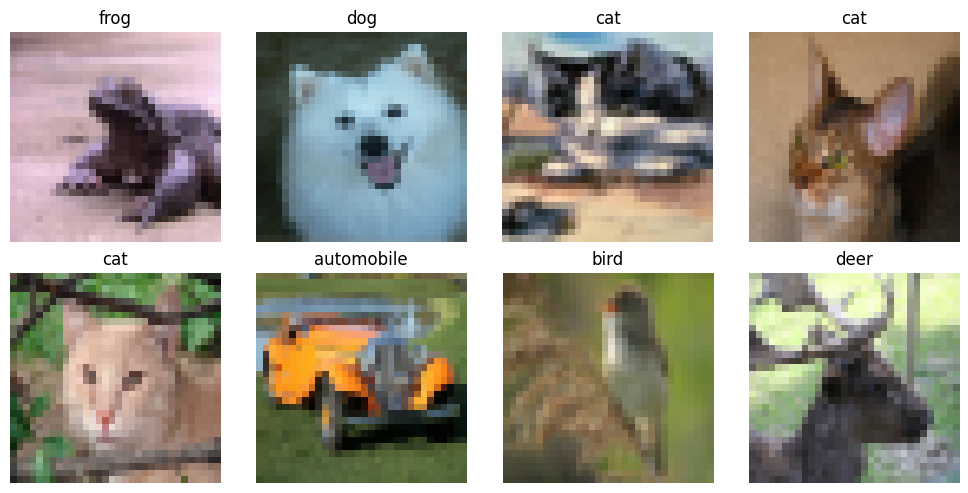

Creating Feed Forward Network Architecture:
Layer 1: Linear(3072 → 512)
         + BatchNorm1d(512)
         + Dropout(0.3)
Layer 2: Linear(512 → 256)
         + BatchNorm1d(256)
         + Dropout(0.3)
Layer 3: Linear(256 → 128)
         + BatchNorm1d(128)
         + Dropout(0.3)
Output:  Linear(128 → 10)
         + Softmax (applied during training)

Total Parameters:
  Total: 1,740,682
  Trainable: 1,740,682

Starting Model Training...

Training for 20 epochs...
Format: Epoch [batch/total] Loss: X.XXX Acc: XX.X%
------------------------------------------------------------
Epoch  1 [  0/704] Loss: 2.355 Acc: 13.3% LR: 0.001000
Epoch  1 [100/704] Loss: 1.938 Acc: 26.1% LR: 0.001000
Epoch  1 [200/704] Loss: 1.879 Acc: 28.4% LR: 0.001000
Epoch  1 [300/704] Loss: 1.771 Acc: 29.8% LR: 0.001000
Epoch  1 [400/704] Loss: 1.770 Acc: 30.8% LR: 0.001000
Epoch  1 [500/704] Loss: 1.934 Acc: 31.7% LR: 0.001000
Epoch  1 [600/704] Loss: 1.664 Acc: 32.3% LR: 0.001000
Epoch  1 [700/704] Loss: 1.825 Acc

In [ ]:

def main():
    print("PYTORCH FEED-FORWARD NEURAL NETWORK")
    print("FOR CINIC-10 IMAGE CLASSIFICATION")
    print("=" * 60)

    # Step 1: Load and split data
    cinic10_path = "/content/drive/MyDrive/cinic-10"

    # Specifying the train, validation, and test datasets
    train_sample_percent = 100
    val_sample_percent = 100
    test_sample_percent = 20


    train_loader, valid_loader, test_loader, class_names, full_valid_dataset, full_test_dataset = load_cinic10_data(
        data_path=cinic10_path,
        batch_size=128,
        train_sample_percent=train_sample_percent,
        val_sample_percent=val_sample_percent,
        test_sample_percent=test_sample_percent,
        random_seed=42
    )

    # Show sample data
    show_sample_data(train_loader, class_names)

    # Step 2: Create model + loss
    model = FeedForwardNet(input_size=3072, num_classes=len(class_names))
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Step 3: Train model (with validation)
    history = train_model(model, train_loader, valid_loader, criterion, num_epochs=20, device=device)

    # Step 4: Final evaluation on the SUBSETTED TEST set and capture Confidences
    print("\nStep 4: Final evaluation on SUBSETTED TEST set...")
    test_loss, test_accuracy, predictions, targets, confidences = evaluate_model(model, test_loader, criterion, device, verbose=True)

    # Step 5: Visualizations: Plot training history (using validation metrics for validation curves)
    history_for_plotting = {
        'train_loss': history['train_loss'],
        'train_acc': history['train_acc'],
        'val_loss': history['val_loss'], # Using validation loss for the validation curve
        'val_acc': history['val_acc']   # Using validation accuracy for the validation curve
    }
    plot_training_history(history_for_plotting)

    # Plot confusion matrix and classification report
    plot_confusion_matrix(predictions, targets, class_names)
    show_classification_report(predictions, targets, class_names)

    # NEW Step: Visualize sample predictions with probabilities
    visualize_sample_predictions(model, test_loader, class_names, num_images=10, device=device)

    # Step 6: Save model
    torch.save(model.state_dict(), 'feedforward_pytorch_model.pth')
    print("Model saved as 'feedforward_pytorch_model.pth'")

    return model, history, test_accuracy


if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)
    model, history, accuracy = main()